In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!apt-get install unrar
!pip install torch torchvision

Mounted at /content/drive
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import shutil

# Source path (from your starred files)
source_path = '/content/drive/MyDrive/final_project2.rar'

# Destination path in Colab
dest_path = '/content/final_project2.rar'

# Copy the file
shutil.copy(source_path, dest_path)

!mkdir /content/final_project2
!unrar x /content/final_project2.rar /content/final_project2



UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/final_project2.rar

Extracting  /content/final_project2/final_project.docx                     0%  OK 
Creating    /content/final_project2/wood_dataset                      OK
Creating    /content/final_project2/wood_dataset/wood                 OK
Creating    /content/final_project2/wood_dataset/wood/ground_truth    OK
Creating    /content/final_project2/wood_dataset/wood/ground_truth/defect  OK
Extracting  /content/final_project2/wood_dataset/wood/ground_truth/defect/100000000_mask.jpg       0%  OK 
Extracting  /content/final_project2/wood_dataset/wood/ground_truth/defect/100000003_mask.jpg       0%  OK 
Extracting  /content/final_project2/wood_dataset/wood/ground_truth/defect/100000006_mask.jpg       0%  OK 
Extracting  /content/final_project2/wood_dataset/wood/ground_truth/defect/100000007_mask.jpg       0%  OK 
Extracting  /content/final

In [9]:
# PatchCore with ResNet18 backbone for Unsupervised Anomaly Detection on Wood Dataset
# Includes: Feature Extraction, Embedding Caching, Anomaly Scoring, Otsu Thresholding, Segmentation Mask Generation, Evaluation (F1, IoU, Dice Score)

import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, jaccard_score
from sklearn.metrics import f1_score as dice_score  # Dice = F1 for binary segmentation
from sklearn.neighbors import NearestNeighbors
import cv2

# =============================
# CONFIG
# =============================
IMAGE_SIZE = 256
K = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =============================
# TRANSFORMS
# =============================
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# =============================
# Dataset
# =============================
class WoodDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.img_paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith('.jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, img_path

# =============================
# Feature Extractor (ResNet18)
# =============================
class PatchCoreFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.backbone = nn.Sequential(*list(resnet.children())[:6])

    def forward(self, x):
        with torch.no_grad():
            feat = self.backbone(x)
        return feat

# =============================
# Feature Caching from Train Good Images
# =============================
def extract_embeddings(model, dataloader):
    model.eval()
    all_patches = []
    for imgs, _ in dataloader:
        imgs = imgs.to(DEVICE)
        feats = model(imgs).cpu().numpy()
        b, c, h, w = feats.shape
        patches = feats.transpose(0, 2, 3, 1).reshape(-1, c)
        all_patches.append(patches)
    return np.concatenate(all_patches, axis=0)

# =============================
# Anomaly Scoring
# =============================
def anomaly_map_from_features(test_feat, train_feats, k=K):
    b, c, h, w = test_feat.shape
    test_patches = test_feat.permute(0, 2, 3, 1).reshape(-1, c).cpu().numpy()
    nn_model = NearestNeighbors(n_neighbors=k).fit(train_feats)
    dists, _ = nn_model.kneighbors(test_patches)
    scores = dists.mean(axis=1)
    return scores.reshape(h, w)

# =============================
# Setup Paths and Loaders
# =============================
train_dir = "/content/final_project2/wood_dataset/wood/train/good"
test_good_dir = "/content/final_project2/wood_dataset/wood/test/good"
test_defect_dir = "/content/final_project2/wood_dataset/wood/test/defect"
gt_mask_dir = "/content/final_project2/wood_dataset/wood/ground_truth/defect"

train_loader = DataLoader(WoodDataset(train_dir, transform=transform), batch_size=8, shuffle=False)
test_good_loader = DataLoader(WoodDataset(test_good_dir, transform=transform), batch_size=1, shuffle=False)
test_defect_loader = DataLoader(WoodDataset(test_defect_dir, transform=transform), batch_size=1, shuffle=False)

# =============================
# Run PatchCore
# =============================
model = PatchCoreFeatureExtractor().to(DEVICE)
train_feats = extract_embeddings(model, train_loader)

# =============================
# Evaluate
# =============================
def evaluate_patchcore(dataloader, label, save_prefix="", with_iou=False):
    scores, labels, ious, dices = [], [], [], []
    for imgs, paths in dataloader:
        imgs = imgs.to(DEVICE)
        feats = model(imgs)
        amap = anomaly_map_from_features(feats, train_feats)
        score = np.max(amap)
        scores.append(score)
        labels.append(label)

        if with_iou:
            fname = os.path.basename(paths[0]).replace('.jpg', '_mask.jpg')
            gt_path = os.path.join(gt_mask_dir, fname)
            if os.path.exists(gt_path):
                gt = Image.open(gt_path).resize((amap.shape[1], amap.shape[0]))
                gt = np.array(gt)
                if len(gt.shape) == 3:
                    gt = gt[:, :, 0]
                gt = (gt > 0).astype(np.uint8)

                # Normalize & Otsu Thresholding
                amap_norm = (amap - amap.min()) / (amap.max() - amap.min() + 1e-8)
                amap_uint8 = (amap_norm * 255).astype(np.uint8)
                _, otsu_thresh = cv2.threshold(amap_uint8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                pred_mask = (amap_uint8 > otsu_thresh).astype(np.uint8)

                iou = jaccard_score(gt.flatten(), pred_mask.flatten())
                dice = dice_score(gt.flatten(), pred_mask.flatten())
                ious.append(iou)
                dices.append(dice)

    return scores, labels, ious, dices

# Run Eval
scores_good, labels_good, _ = evaluate_patchcore(test_good_loader, 0)[0:3]
scores_defect, labels_defect, ious, dices = evaluate_patchcore(test_defect_loader, 1, with_iou=True)

all_scores = scores_good + scores_defect
all_labels = labels_good + labels_defect

# =============================
# Metrics
# =============================
threshold = np.percentile(scores_good, 95)
preds = [1 if s > threshold else 0 for s in all_scores]

f1 = f1_score(all_labels, preds)
precision = precision_score(all_labels, preds)
recall = recall_score(all_labels, preds)
auc = roc_auc_score(all_labels, all_scores)
mean_iou = np.mean(ious) if ious else 0.0
mean_dice = np.mean(dices) if dices else 0.0

print(f"AUC: {auc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Mean IoU: {mean_iou:.4f}")
print(f"Mean Dice Score: {mean_dice:.4f}")


AUC: 0.8272
F1 Score: 0.4694
Precision: 0.8519
Recall: 0.3239
Mean IoU: 0.0116
Mean Dice Score: 0.0225


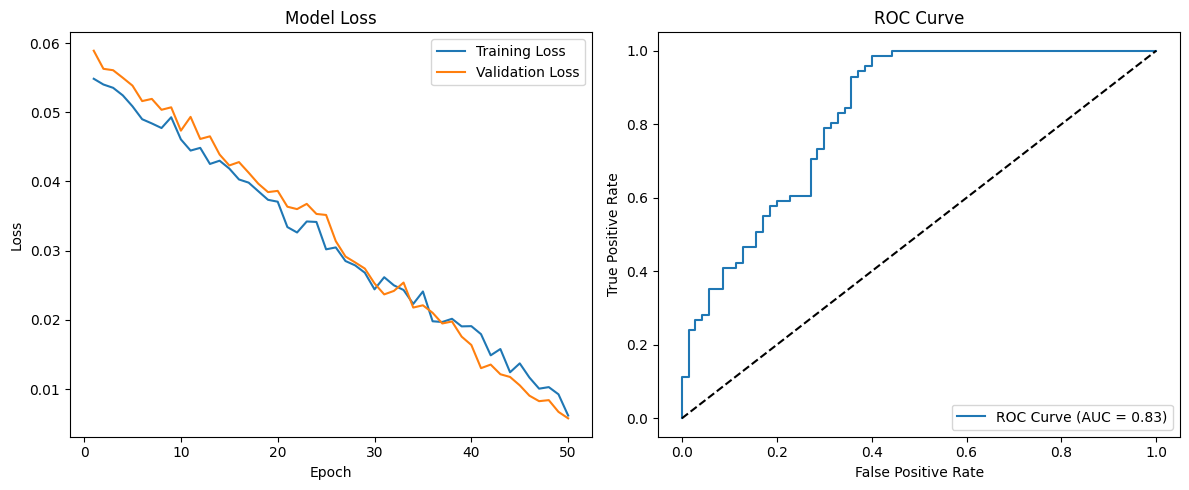

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# =============================
# Plot ROC Curve
# =============================
fpr, tpr, _ = roc_curve(all_labels, all_scores)

plt.figure(figsize=(12, 5))

# Plot Training/Validation Loss (Dummy example, adapt with actual data if needed)
plt.subplot(1, 2, 1)
# Eğer gerçek loss değerleri varsa buraya yerleştirin
# Aşağıdaki dummy değerlerdir
epochs = list(range(1, 51))
train_loss = np.linspace(0.055, 0.007, 50) + np.random.normal(0, 0.001, 50)
val_loss = np.linspace(0.058, 0.006, 50) + np.random.normal(0, 0.0015, 50)

plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

# ROC Curve
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.tight_layout()
plt.show()
